`wu_integer_noisey_spikey_05.ipynb`

> data: `generating_data/data/wu_10000_normal-uniform-noise_5-percent-normal-pi-spike_integer-taus.bz2`

> Attempt to correctly compute *integer* tau for each entry

> Reducing to 3 layers

> trying random some random layer node combinations

> change cost to std

##### imports and notebook setup

In [1]:
import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, glob, sys, io

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter

from plot_styles import set_plotstyles
set_plotstyles()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### load data

In [2]:
# glob.glob("../generating_data/data/*")
data = pd.read_csv('../generating_data/data/wu_10000_normal-uniform-noise_5-percent-normal-pi-spike_integer-taus', compression = 'bz2')

#### split data

In [3]:
# split randomly 80% / 10%
training_data_df = data.sample(frac = 0.8)
testing_data_df = data.loc[~data.index.isin(training_data_df.index)]

# separate input features from output
X_training = training_data_df.drop('tau', axis = 1).values
y_training = training_data_df[['tau']].values

X_testing = testing_data_df.drop('tau', axis = 1).values
y_testing = testing_data_df[['tau']].values

#### scale data

In [4]:
# setup data scalers
X_scaler = MinMaxScaler(feature_range = (0,1))
y_scaler = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training = X_scaler.fit_transform(X_training)
y_scaled_training = y_scaler.fit_transform(y_training)

X_scaled_testing = X_scaler.transform(X_testing)
y_scaled_testing = y_scaler.transform(y_testing)

#### declare hyper-parameters

In [8]:
number_of_inputs =  X_scaled_training.shape[1]
number_of_outputs = y_scaled_training.shape[1]

# layer_1_nodes_range = np.random.randint(32, high = 1024, size = 10)
# layer_2_nodes_range = np.random.randint(32, high = 1024, size = 10)
# layer_3_nodes_range = np.random.randint(32, high = 1024, size = 10)

training_epochs = 1000
learning_rate = 0.0001

# nodes = np.array([(n1,n2,n3) for n1 in layer_1_nodes_range for n2 in layer_2_nodes_range for n3 in layer_3_nodes_range])
# nodes_choices = nodes[np.random.choice(range(len(nodes)), 9)]
nodes_choices = [[768, 512, 256]]

#### setup log path

In [6]:
# one random serial number per NN graph
# - add letters to end for repeated runs
# - only run this cell once!
log_random_serial_number = '{}'.format(np.random.randint(10000,99999))
# log_random_serial_number = 25352
log_random_serial_number

'43981'

In [7]:
def log_dir(log_random_serial_number):
    master_log_path = '../logs/'
    log_num = len(glob.glob(master_log_path + log_random_serial_number + '*'))
    
    direc = master_log_path + log_random_serial_number
    if log_num > 0:
        # assumes less than 26 runs per graph
        direc += chr(ord('@') + log_num)
    return direc

In [9]:
def reduce_var(x, axis=None, keepdims=False):
    """Variance of a tensor, alongside the specified axis.

    # Arguments
        x: A tensor or variable.
        axis: An integer, the axis to compute the variance.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.

    # Returns
        A tensor with the variance of elements of `x`.
    """
    m = tf.reduce_mean(x, axis=axis, keep_dims=True)
    devs_squared = tf.square(x - m)
    return tf.reduce_mean(devs_squared, axis=axis, keep_dims=keepdims)

def reduce_std(x, axis=None, keepdims=False):
    """Standard deviation of a tensor, alongside the specified axis.

    # Arguments
        x: A tensor or variable.
        axis: An integer, the axis to compute the standard deviation.
        keepdims: A boolean, whether to keep the dimensions or not.
            If `keepdims` is `False`, the rank of the tensor is reduced
            by 1. If `keepdims` is `True`,
            the reduced dimension is retained with length 1.

    # Returns
        A tensor with the standard deviation of elements of `x`.
    """
    return tf.sqrt(reduce_var(x, axis=axis, keepdims=keepdims))


#### loop through nodes

Instructions for updating:
keep_dims is deprecated, use keepdims instead
../logs/43981
 epoch:  999 testing_cost: 0.01816685870289802551

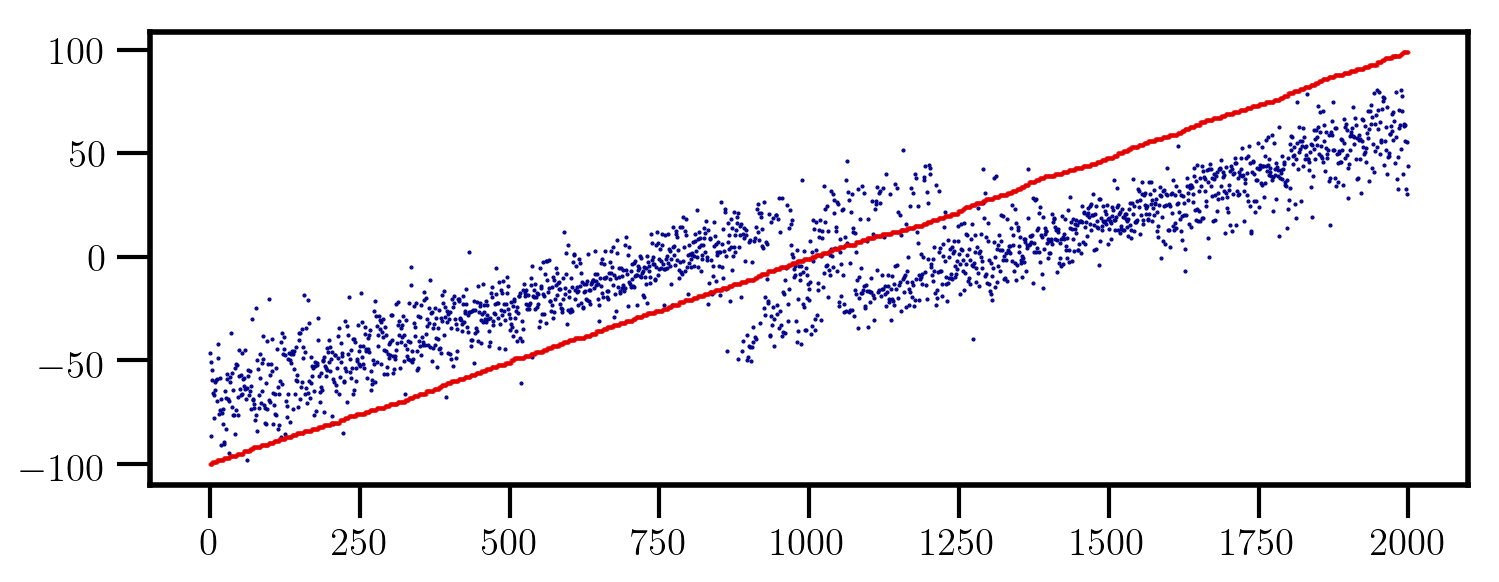

46.15275699565008
11.737983003625281


In [11]:
for node_vals in nodes_choices:
    
    layer_1_nodes = node_vals[0]
    layer_2_nodes = node_vals[1]
    layer_3_nodes = node_vals[2]

    tf.reset_default_graph()

    with tf.variable_scope('input'):
        X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

    with tf.variable_scope('keep'):
        keep_prob = tf.placeholder(tf.float32)

    with tf.variable_scope('layer_1'):

        biases = tf.get_variable(name = "biases1", shape = [layer_1_nodes], initializer = tf.zeros_initializer())
        weights = tf.get_variable(name = "weights1", shape  = [number_of_inputs, layer_1_nodes], initializer = tf.contrib.layers.xavier_initializer())
        layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

    with tf.variable_scope('layer_2'):

        biases = tf.get_variable(name = "biases2", shape = [layer_2_nodes], initializer = tf.zeros_initializer())
        weights = tf.get_variable(name = "weights2", shape  = [layer_1_nodes, layer_2_nodes], initializer = tf.contrib.layers.xavier_initializer())
        layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

    with tf.variable_scope('layer_3'):

        biases = tf.get_variable(name = "biases3", shape = [layer_3_nodes], initializer = tf.zeros_initializer())
        weights = tf.get_variable(name = "weights3", shape  = [layer_2_nodes, layer_3_nodes], initializer = tf.contrib.layers.xavier_initializer())
        layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

    with tf.variable_scope('output'):

        biases = tf.get_variable(name = "biases_out", shape = [number_of_outputs], initializer = tf.zeros_initializer())
        weights = tf.get_variable(name = "weights_out", shape  = [layer_3_nodes, number_of_outputs], initializer = tf.contrib.layers.xavier_initializer())
        prediction = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

    with tf.variable_scope('cost'):

        y = tf.placeholder(tf.float32, shape = (None, 1))
        cost = reduce_std(tf.squared_difference(prediction, y))

    with tf.variable_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

    with tf.variable_scope('logging'):
        tf.summary.scalar('current_cost', cost)
        tf.summary.histogram('predictions', prediction)
        summary = tf.summary.merge_all()


    saver = tf.train.Saver()
    log_direc = log_dir(str(43981))
    print(log_direc)


    with tf.Session() as session:

        session.run(tf.global_variables_initializer())

        training_writer = tf.summary.FileWriter(log_direc + '/training', session.graph)
        testing_writer = tf.summary.FileWriter(log_direc + '/testing', session.graph)
        model_save_location = log_direc + '/model/trained_model.ckpt'


        for epoch  in range(training_epochs):

            # Feed in the training data and do one step NN training
            session.run(optimizer,feed_dict = {X: X_scaled_training, y: y_scaled_training, keep_prob: 0.5})

            training_feed = {X: X_scaled_training, y: y_scaled_training, keep_prob: 0.5}
            training_cost, training_summary = session.run([cost, summary], feed_dict = training_feed)

            testing_feed =  {X: X_scaled_testing, y: y_scaled_testing, keep_prob: 0.5}
            testing_cost, testing_summary = session.run([cost, summary],feed_dict = testing_feed)

            sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.20f}'.format(epoch, testing_cost))

            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)
            testing_writer.flush()
            training_writer.flush()

            if epoch % 50 == 0:
                    saver.save(session, model_save_location, epoch)

        saver.save(session, model_save_location, epoch)
        
        prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing, keep_prob: 1})
    
        # the predictions but in the original units
        prediction_unscaled = y_scaler.inverse_transform(prediction_scaled)
        
        sorting_idx = np.argsort(y_testing.T[0])

    fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)
    
    ax.plot(prediction_unscaled.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1,
            color = 'darkblue')
    
    ax.plot(y_testing.T[0][sorting_idx],
            linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
            color = '#E50000')
    
    plt.show()
    
    print(sum((y_scaled_testing.T[0] - prediction_scaled.T[0])**2))
    
    print(np.std(abs(y_testing.T[0] - prediction_unscaled.T[0])))